# <center> Gender Biais detection</center>
## <center> Application of the Bolukbasi Paper to the french  </center>
### <center> Quillivic Robin </center>
Sources : Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings, Bolukbasi, Tolga, 2016

In [8]:
from gensim import *
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
import logging
import gensim
import os

import itertools

from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
from random import *

import pandas as pd
import numpy as np
import math

from sklearn.decomposition import PCA
import lib
import fasttext
from gensim.models.wrappers import FastText

In [272]:
# Logging code taken from http://rare-technologies.com/word2vec-tutorial/
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Load pre-trained Word2Vec model.
#model  = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\FR\cc.fr.300.vec', binary=False,limit=50000)
#model  = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\FR\frWac_no_postag_no_phrase_500_skip_cut100.bin', binary=True,limit=50000)
model  = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\FR\fr_Kyubyong_wordvectors.vec',binary=False,limit=50000)
#model  = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\FR\wiki_fr.vec',binary=False,limit=50000)

# normalizeation :
model.init_sims(True)

2019-02-24 14:23:40,906 : INFO : loading projection weights from DATA\FR\fr_Kyubyong_wordvectors.vec
2019-02-24 14:23:54,036 : INFO : loaded (50000, 300) matrix from DATA\FR\fr_Kyubyong_wordvectors.vec
2019-02-24 14:23:54,052 : INFO : precomputing L2-norms of word weight vectors


## Find gender direction for French

In [249]:
def association_Genrator(w1,w2,model,top_n=1000):
    """
    return a data frame ordered by the most similar pair of the W1,W2
    """
    # we build a dataframe with the vocabulary
    df = pd.DataFrame(list(model.wv.vocab.items()), columns=['word','count'])
    # we drop the index of the word entry
    k = df[df['word']==w1].index[0]
    j = df[df['word']==w2].index[0]
    liste = df['word'].drop([k,j]).values[:top_n]
    # we compute the length of the iteration to informethe user that the process could be long
    N=math.factorial(len(liste))/(math.factorial(len(liste)-2)*math.factorial(2))
    # init
    a = model.wv[w1]-model.wv[w2]
    S =[]
    P=[]
    i=0
    # we compute the similarity score
    for x in itertools.combinations(liste,2) :
        u = model.wv[x[0]]-model.wv[x[1]]
        S.append(lib.cosine_similarity(a,u))
        P.append(x)
        i+=1
        # print the progression
        if i%1000000==0:
            print(i/N*100,'%')
            
    # storing and ordering
    res = pd.DataFrame(data={'pair':P,'score':S})
    res['score'] = abs(res['score']) #get absolute value
    res = res.sort_values(by='score',ascending=False,inplace=False)
    return(res)

In [285]:
res_HF = association_Genrator('fille','garçon',model,top_n=1000)
res_HF.head(20)

C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


,pair,score
234533,"(petit, épouse)",0.528391
272360,"(jeune, épouse)",0.516078
331251,"(homme, épouse)",0.493684
401258,"(jeunes, épouse)",0.492830
393131,"(personnage, épouse)",0.469869
419760,"(l'école, épouse)",0.467365
170706,"(club, épouse)",0.463942
234519,"(petit, marie)",0.458909
394050,"(joueur, épouse)",0.458562
442495,"(épouse, j'ai)",0.455355


In [185]:
list(res_HF['pair'][:15])

[('laquelle', 'lequel'),
 ('un', 'une'),
 ('son', 'sa'),
 ('seul', 'seule'),
 ('ce', 'cette'),
 ('de', 'un'),
 ('tout', 'toute'),
 ('un', 'cette'),
 ('son', 'cette'),
 ('une', 'ce'),
 ('celui', 'celle'),
 ('de', 'du'),
 ('cette', 'lequel'),
 ('un', 'sa'),
 ('ce', 'toute')]

## 1) Direct Bais

In [282]:
pair_g = [['la','le'],['elle','il'], ['appelée', 'appelé'],
          ['une','un'],['laquelle', 'lequel'],['cette', 'ce'],['seule', 'seul'],['celle','celui'],
          ['mienne','mien']]

genre = [['la','le'],['maman','papa'],['mère','père'],
         ['fille','fils'],['femelle','mâle'],
          ['femme','homme'], ['actrice','acteur'],['serveuse','serveur'],['contente' ,'content'],
         ['belle','beau'],['reine','roi']]


# pair_g = [['elle','il'],['la','le'],['mienne','mien'],['sienne','sien'],['une','un'], ['aucune', 'aucun'], ['certaine', 'certain']]

         

In [279]:
lib.cosine_similarity(model['appelée'], model['appelé'])

0.6741334

In [280]:
lib.cosine_similarity(model['appelé'], model['appelée'])

0.6741334

In [283]:
Subs_genre = lib.from_pair_to_subspace(pair_g,model)

direction_g, expl_var_g,eig_values_g = lib.from_space_to_direction(Subs_genre)

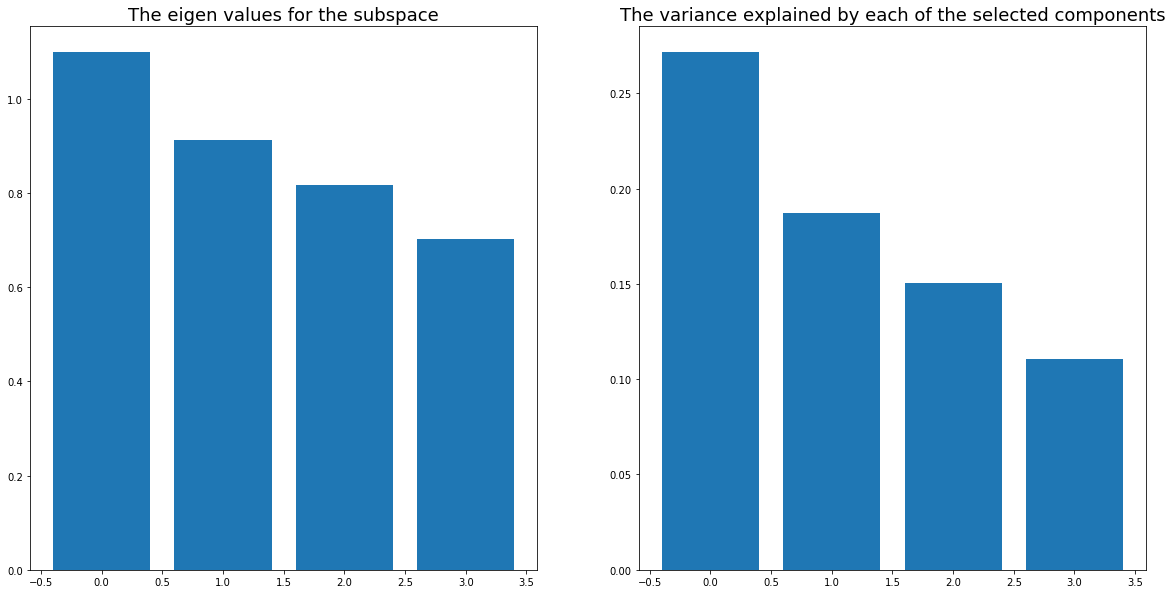

In [284]:
lib.plot_var_eig(eig_values_g,expl_var_g)

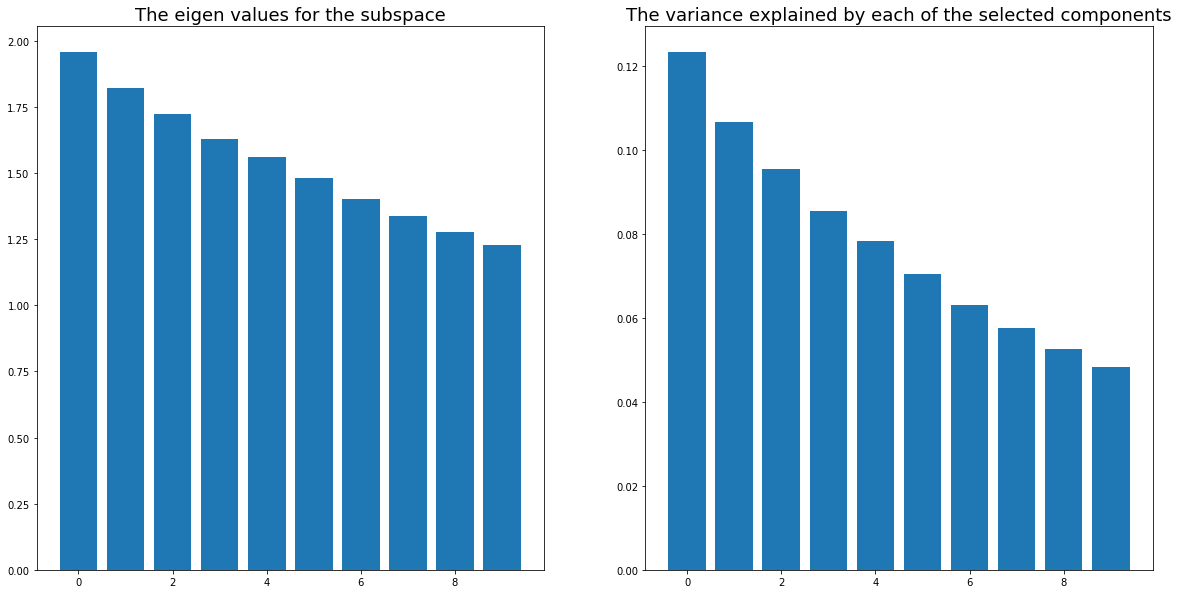

In [211]:
#lib.plot_mean(150,model)

## Exemple of  direct biais

In [265]:
word = ['il','football','amour','aventure','émotion','larme','dance','femme','homme','robe','match']
for w in word :
    print('the direct biais for',w,'is : ', lib.cosine_similarity(model[w],direction_g)*100)

the direct biais for il is :  -3.006753884255886
the direct biais for football is :  0.1985534094274044
the direct biais for amour is :  2.6768287643790245
the direct biais for aventure is :  4.860486462712288
the direct biais for émotion is :  8.58251303434372
the direct biais for larme is :  9.638045728206635
the direct biais for dance is :  3.0237283557653427
the direct biais for femme is :  7.985847443342209
the direct biais for homme is :  12.544450163841248
the direct biais for robe is :  2.6778429746627808
the direct biais for match is :  -0.7036157883703709


In [266]:
neutral_fem =['table','chaise','pomme','banane','roue','enceinte','blague','bouteille','souris','feuille']
for w in neutral_fem :
    print('the direct biais for',w,'is : ', lib.cosine_similarity(model[w],direction_g)*100)

the direct biais for table is :  6.077568605542183
the direct biais for chaise is :  1.687236875295639
the direct biais for pomme is :  7.279232144355774
the direct biais for banane is :  1.613708771765232
the direct biais for roue is :  7.461264729499817
the direct biais for enceinte is :  7.393453270196915
the direct biais for blague is :  7.216731458902359
the direct biais for bouteille is :  6.543096899986267
the direct biais for souris is :  10.838506370782852
the direct biais for feuille is :  -0.8470296859741211


In [267]:
neutral_man =['stylo','kiwi','chocolat','café','véhicule','chateau','rire','casier','clavier','filtre']
for w in neutral_man :
    print('the direct biais for',w,'is : ', lib.cosine_similarity(model[w],direction_g)*100)

the direct biais for stylo is :  -6.339734792709351
the direct biais for kiwi is :  -7.496730983257294
the direct biais for chocolat is :  -5.313262715935707
the direct biais for café is :  1.9855763763189316
the direct biais for véhicule is :  -0.8041643537580967
the direct biais for chateau is :  5.353265628218651
the direct biais for rire is :  -1.7193133011460304
the direct biais for casier is :  4.8095859587192535
the direct biais for clavier is :  -9.162575751543045
the direct biais for filtre is :  0.23198297712951899


## First conclusion :
Thera are a lot of variation depending on what modele we are using and from now on we canot a observe signification for the gender subspace.